In [5]:
#导入包
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mpl_toolkits.axisartist as axisartist
import copy
import matplotlib as mpl 
from scipy import integrate

In [6]:
#周期序列
Q=np.array([7.3,5.0,6.2,6.6,5.7,5.0,9.1])
Q2=np.array([0.35,0.68,0.82,0.18,0.35,0.68,0.82,0.18,0.35,0.68,0.82,0.18])

#随机序列
def random(n):
    return np.random.rand(n)

#分形序列
def conway(n):
    a=np.array([1,1])
    for i in range(2,n):
        a=np.append(a,a[a[i-1]-1]+a[i-a[i-1]])
    return (a-np.array(range(1,n+1))/2)

#周期,n为长度
def sin(n):
    return np.sin(np.linspace(0, n/10, n))+1
    
#混沌序列
def lorenz(p,t,s,r,b):
    x,y,z = p.tolist()          #无质量点的当前位置(x,y,z)
    #print("x,y,z,t:",x,y,z,t)   #帮助理解odeint的执行过程
    return s*(y-x),x*(r-z)-y,x*y-b*z #返回dx/dt,dy/dt,dz/dt
t = np.arange(0,30,0.01)
track1 = integrate.odeint(lorenz,(0.0,1.00,0.0),t,args=(10.0,29.0,2.6))
track2 = integrate.odeint(lorenz,(0.0,1.01,0.0),t,args=(10.0,29.0,2.6))


In [7]:
#对VG效率进行了改进,时间复杂度为n2，但由于使用向量，因此比一般n2快很多
#getVGPoint_z：输入Q，返回VG的连接点数组
def getVGPoint_z(Q):
    #1.初始化斜率数组(长度n)，全设为-Inf
    k=np.array([float("-inf")]*len(Q))
    #初始化两个数组，保存连接点
    #若a，b为俩连接点，a保存在arr1，b保存在arr2
    arr1=np.array([])
    arr2=np.array([])
    #while循环,若k数组长度为1，就停止(或for循环n-1次)
    for i in range(1,len(Q)):
        #2.进行差分，得到新斜率
        k_new=(Q[i:]-Q[:-i])/i
        #3.比较新斜率和原来的斜率
        #若新的斜率大，则替换原来的斜率，并获取其索引值，作为连接的点
        #3.1(连接)获取斜率大对应的索引值并添加到数组中
        #每次k_new都会少一位，所以k也减一位，来与k_new对应
        #k=k[:-1]
        #或者说k每次都少取一位，即用k[:-i]
        big_index=np.where(k_new>k[:-i])
        arr1=np.append(arr1,big_index)
        arr2=np.append(arr2,np.array(big_index)+int(i))
        #3.2(更新)将斜率更新为大的斜率
        k[big_index]=k_new[big_index]
    
    #返回
    return np.array([arr1,arr2]).astype(int)

getVGPoint_z(Q)

array([[0, 1, 2, 3, 4, 5, 0, 3, 4, 0, 3, 2, 0],
       [1, 2, 3, 4, 5, 6, 2, 5, 6, 3, 6, 6, 6]])

In [8]:
#对HVG效率进行了改进,时间复杂度为n2，但由于使用向量，因此比一般n2快很多
#getHVGPoint_z：输入Q，返回HVG的连接点数组
def getHVGPoint_z(Q):
    #1.初始化高度数组(长度n)，全设为-Inf
    h=np.array([float("-inf")]*len(Q))
    #初始化两个数组，保存连接点
    #若a，b为俩连接点，a保存在arr1，b保存在arr2
    arr1=np.array([])
    arr2=np.array([])
    #while循环,若k数组长度为1，就停止(或for循环n-1次)
    for i in range(1,len(Q)):
        #2.进行差分，保存两个之间更小的那个
        a=np.array(Q[:-i])
        b=np.array(Q[i:])
        index=b<a
        a[index]=b[index]
        h_new=a
        #3.比较新高度和原来的高度
        #若新的高度大，则替换原来的高度，并获取其索引值，作为连接的点
        #3.1(连接)获取斜率大对应的索引值并添加到数组中
        #每次k_new都会少一位，所以k每次都少取一位，即用k[:-i]
        big_index=np.where(h_new>h[:-i])
        arr1=np.append(arr1,big_index)
        arr2=np.append(arr2,np.array(big_index)+int(i))
        #3.2(更新)将高度更新为大的高度
        h[big_index]=h_new[big_index]
    
    #返回
    return np.array([arr1,arr2]).astype(int)

getHVGPoint_z(Q2)

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  2,  6,  2,  6,  2,
         6],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  4,  8,  5,  9,  6,
        10]])

In [9]:
#DVG
def getDVGPoint(Q):
    #得到VG,HVG的连接点
    VG_arr=getVGPoint_z(Q)
    HVG_arr=getHVGPoint_z(Q)
    
    #由于HVG是VG的子图
    #我们将HVG的点，在VG中剔除，得到DVG的连接点
    
    #1.转成两两一组的数组
    VG_arrb=[]
    for i in range(0,len(VG_arr[0])):
        VG_arrb.append([VG_arr[0][i],VG_arr[1][i]])
    HVG_arrb=[]
    for i in range(0,len(HVG_arr[0])):
        HVG_arrb.append([HVG_arr[0][i],HVG_arr[1][i]])
    
    #2.剔除
    #先令DVG等于VG，再一步步剔除
    DVG_arrb=copy.deepcopy(VG_arrb)
    #再剔除
    for i in HVG_arrb:
        DVG_arrb.remove(i)
    
    #3.转回原来形式的数组
    arr1=[]
    for i in range(0,len(DVG_arrb)):
        arr1.append(DVG_arrb[i][0])

    arr2=[]
    for i in range(0,len(DVG_arrb)):
        arr2.append(DVG_arrb[i][1])

    DVG_arr=[arr1,arr2] 
        
    #输出
    #print('VG:',VG_arr)
    #print('HVG:',HVG_arr)
    #print('DVG:',DVG_arr)
    
    #返回
    return DVG_arr

getDVGPoint(Q2)

[[3, 7], [5, 9]]

[[3, 2], [5, 6]]


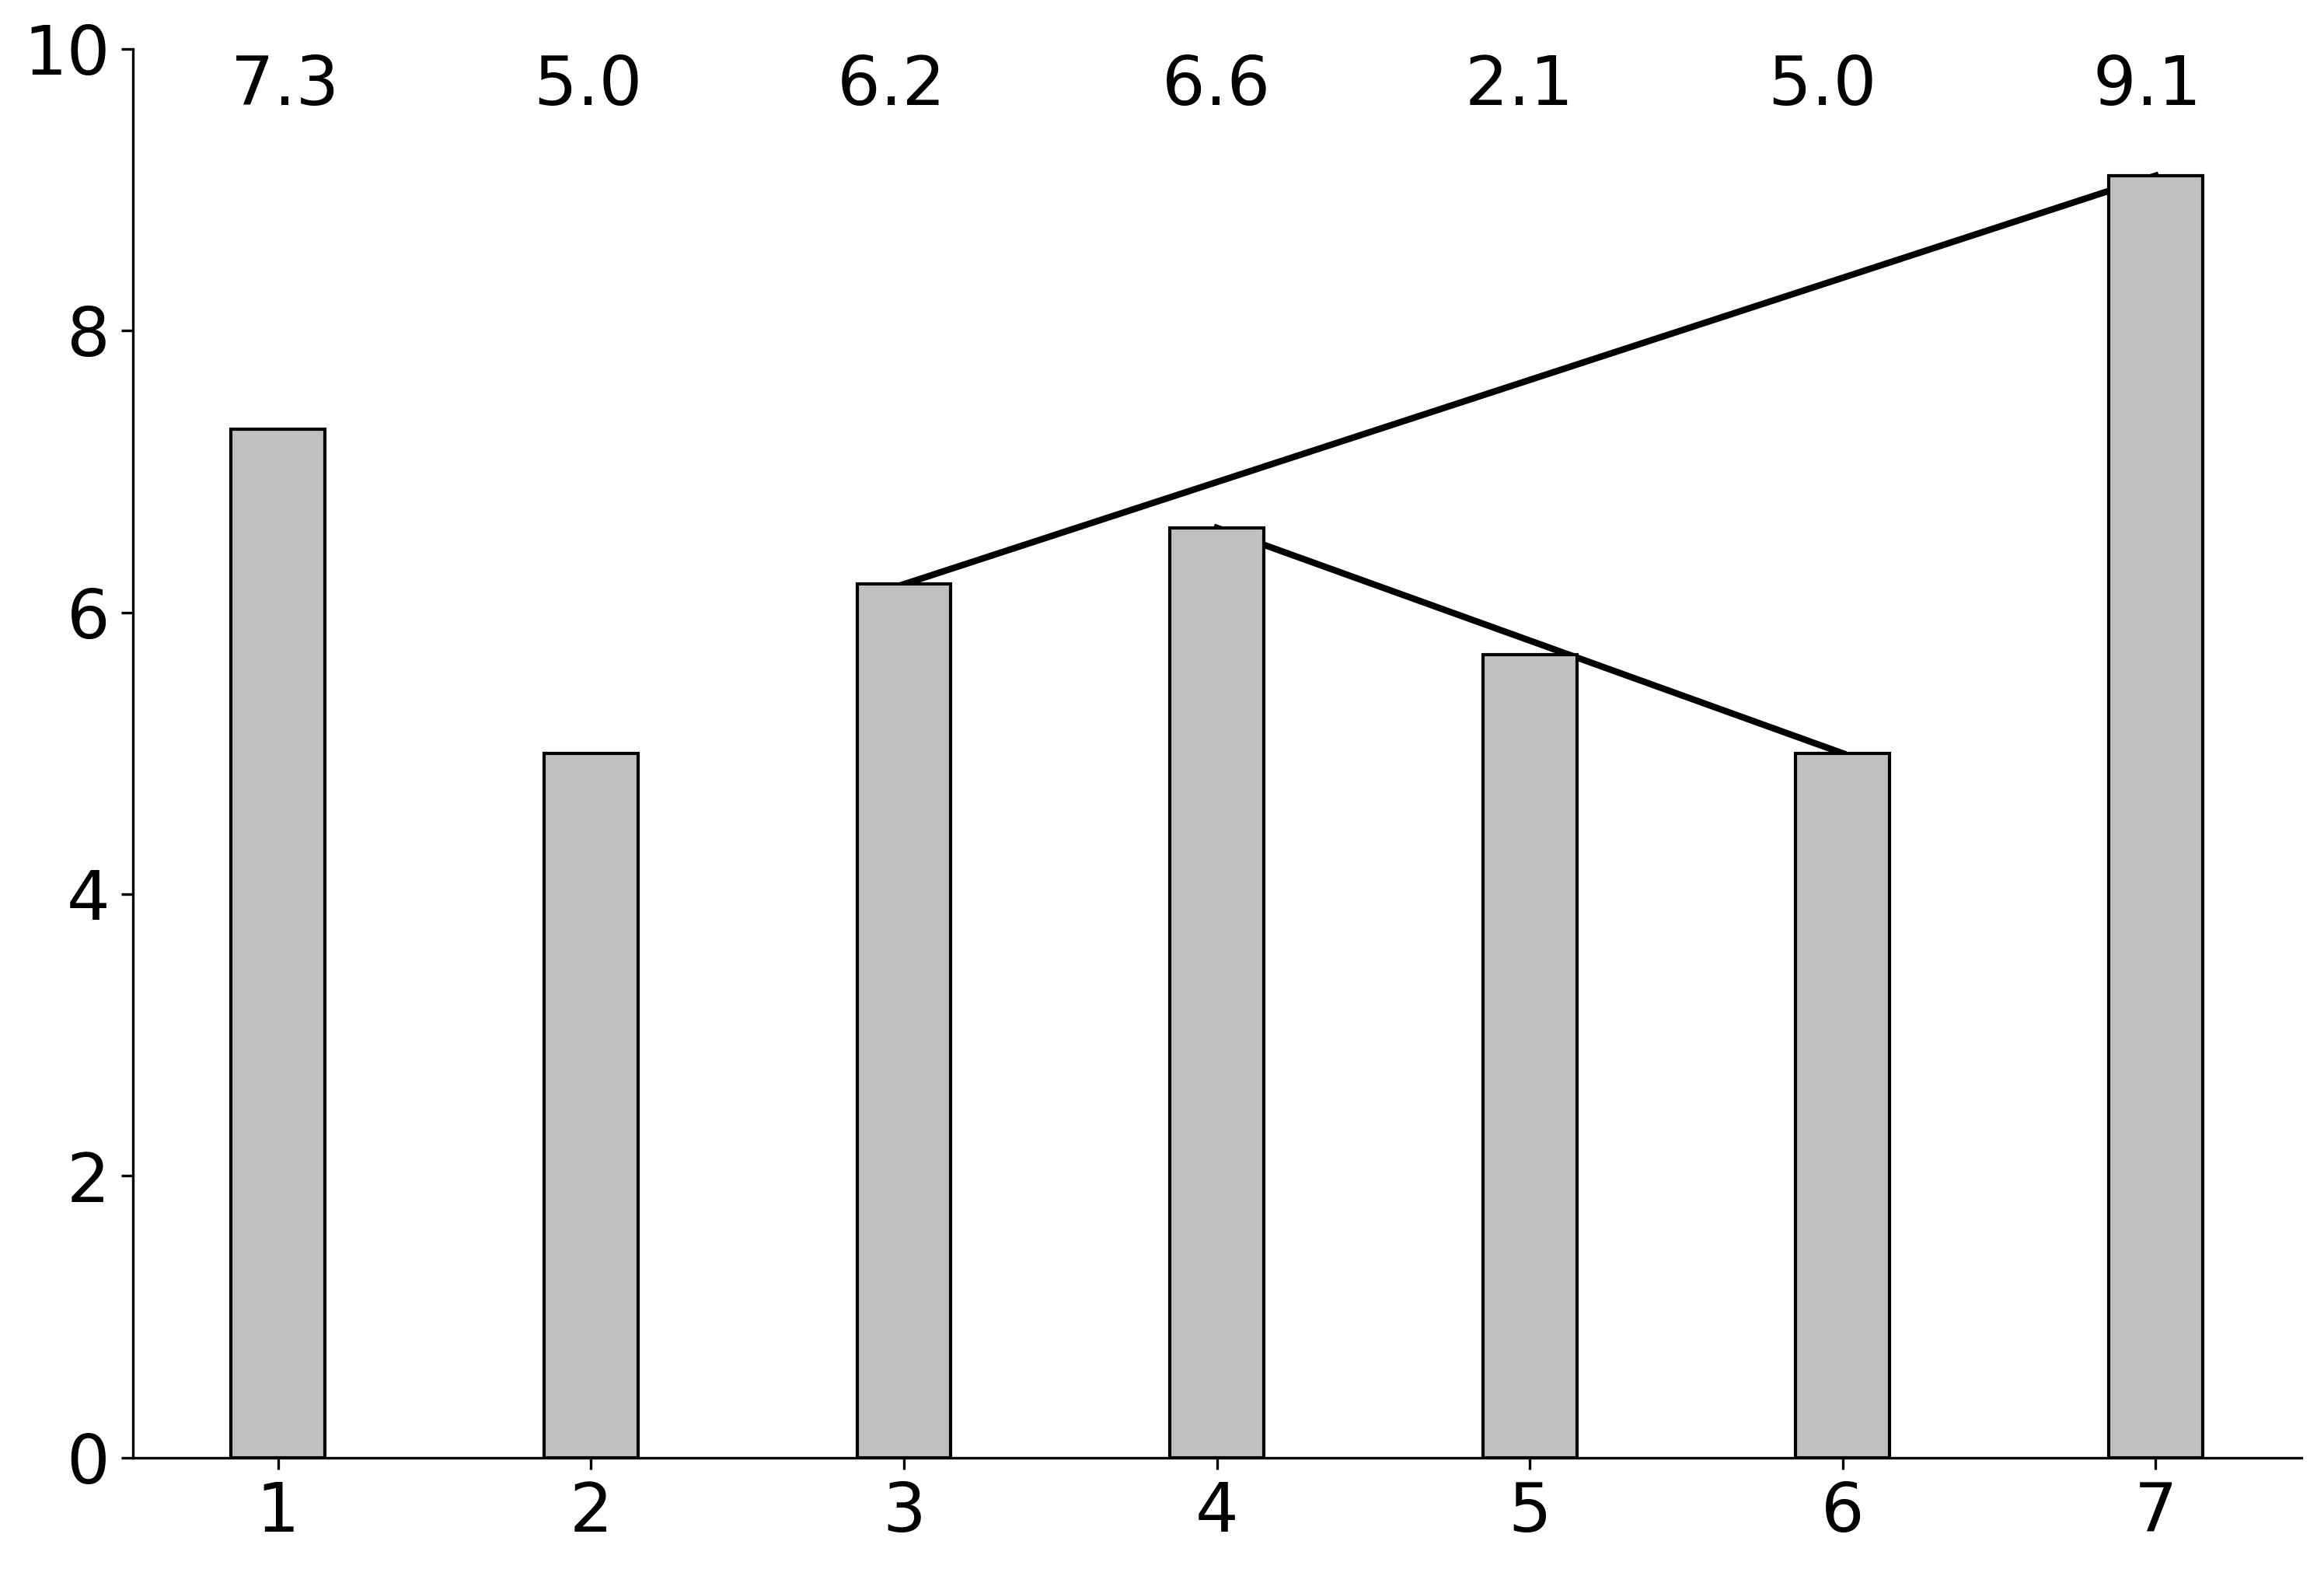

In [10]:
#VG_bar函数：输入序列Q，输出VG条形图（需先调用getVGPoint函数）
def DVG_bar(Q):
    #准备画布，和一个坐标轴
    fig = plt.figure(figsize=(12, 8), dpi=300)#设置图形大小
    ax = fig.add_subplot(111)
    
    #将绘图区对象添加到画布中
    fig.add_axes(ax)
    
    #设置样式
    #ax.set_yticks([])#不显示y坐标轴标签
    plt.ylim(0,10)
    plt.tick_params(labelsize=18)
    ax.spines['top'].set_visible(False)#不显示上边框
    ax.spines['right'].set_visible(False)#不显示右边框
    
    #画条形图
    x= np.array(range(0,len(Q)))
    p1=ax.bar(x,Q,width=0.3,color='#C0C0C0',edgecolor='black',zorder=10)

    #获取要连接两点的坐标
    arr=getDVGPoint(Q)

    #在图中连接两点
    print(arr)
    for i in range(0,len(arr[0])):
        p2=ax.plot([arr[0][i],arr[1][i]],[Q[arr[0][i]],Q[arr[1][i]]],color='black',linewidth=2,zorder=0)
    
    #设置x轴刻度的值（为直方条高度），调整字体大小
    plt.xticks(x,range(1, len(Q) + 1),fontsize=21)
    plt.yticks(fontsize=21)
    
    
    plt.text(-0.15, 9.6, "7.3         5.0         6.2          6.6         2.1         5.0          9.1", size=21,
        bbox=dict(boxstyle="square",
                 color="#FFFFFF"
                  )
        )
    #显示图像
    plt.rcParams['xtick.direction'] = 'in' #将x轴的刻度线方向设置向内
    plt.rcParams['ytick.direction'] = 'in' #将y轴的刻度方向设置向内
    
    #保存图片
    #plt.savefig('E:\\DVG_bar.png',bbox_inches="tight",dpi=600)
    
    #显示图像
    plt.show()
    
#调用
Q=np.array([7.3,5.0,6.2,6.6,5.7,5.0,9.1])
DVG_bar(Q)

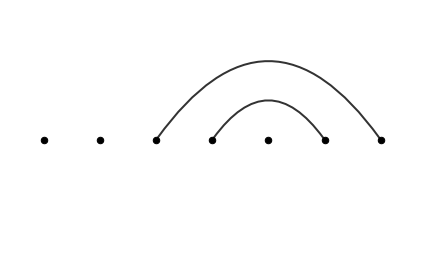

In [11]:
# %matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math

def DVG_net(Q):
    arr=getDVGPoint(Q)
    x=np.array(range(0,len(Q)))
    G = nx.Graph()        # 无多重边有向图

    #点
    G.add_nodes_from(x)  # 添加多个节点

    #边
    for i in range(0,len(arr[0])):
        if arr[1][i]-arr[0][i]==1:
            G.add_edges_from([(arr[0][i],arr[1][i])],rad=0)
        else:
            G.add_edges_from([(arr[0][i],arr[1][i])],rad=0.7)

    #位置
    pos=dict()
    for i in range(len(Q),-1,-1):
        sd={i:(i,0)}
        pos={**sd,**pos}
    # pos = {0: (0, 0), 1: (1, 0), 2: (2, 0), 3: (3,0), 4: (4, 0),5: (5, 0), 6: (6, 0), 7: (7, 0), 8: (8,0), 9: (9, 0),10: (10, 0), 11: (11, 0), 12: (12, 0)}

    #画点
    nx.draw_networkx_nodes(G, pos, node_size=42, nodelist=x, node_color="black")

    ax = plt.gca()

    #画边
    edge1=[[],[]]#存储边
    for edge in G.edges(data=True):
        edge1[0].append(edge[0])
        edge1[1].append(edge[1])
        
        if edge[2]["rad"]==0:
            #nx.draw_networkx_edges(G, pos, edgelist=[edge],arrowstyle="-", connectionstyle=f'arc3, rad = -{edge[2]["rad"]}')
            arrowprops=dict(arrowstyle="-",color='black',connectionstyle=f'arc3, rad = -{edge[2]["rad"]}',linestyle= '-',alpha=0.8,)
            ax.annotate("", xy=[edge[0],0], xytext=[edge[1],0],arrowprops=arrowprops)
        else:
            for i in range(len(edge1[0])):
                #判断边是否与前面某条边有交叉，如果有就在下边画
                panduan=edge[0]>edge1[0][i] and edge[0]<edge1[1][i] and edge[1]>edge1[1][i]
                if panduan:
                    #print(edge[0],edge[1])
                    #nx.draw_networkx_edges(G, pos, edgelist=[edge], connectionstyle=f'arc3, rad = {edge[2]["rad"]}')
                    arrowprops=dict(arrowstyle="-",color='black',connectionstyle=f'arc3, rad = -{edge[2]["rad"]}',linewidth=2,linestyle= '-',alpha=0.8,)
                    ax.annotate("", xy=[edge[0],0], xytext=[edge[1],0],arrowprops=arrowprops)
                    break
            #如果没有就在上边画
            if i==len(edge1[0])-1 and not panduan:
                #print(edge[0],edge[1])
                #nx.draw_networkx_edges(G, pos, edgelist=[edge], connectionstyle=f'arc3, rad = -{edge[2]["rad"]}')
                arrowprops=dict(arrowstyle="-",color='black',connectionstyle=f'arc3, rad = {edge[2]["rad"]}',linewidth=2,linestyle= '-',alpha=0.8,)
                ax.annotate("", xy=[edge[0],0], xytext=[edge[1],0],arrowprops=arrowprops)
    
    
    ax.margins(0.11)
    plt.tight_layout()
    plt.axis("off")
    #plt.savefig('E:\\DVG_net.png',dpi=600)
    plt.show()

DVG_net(Q)